### Import libraries

In [1]:
import csv
import re
import numpy as np
import pandas as pd
import matplotlib as mp
import math as m

### Download the training and test data set

In [2]:
url_train_dev = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTOZ2rC82rhNsJduoyKYTsVeH6ukd7Bpxvxn_afOibn3R-eadZGXu82eCU9IRpl4CK_gefEGsYrA_oM/pub?gid=1863430984&single=true&output=tsv'
url_test = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-KNR9nuYatLkSbzSRgpz6Ku1n4TN4w6kKmFLkA6QJHTfQzmX0puBsLF7PAAQJQAxUpgruDd_RRgK7/pub?gid=417546901&single=true&output=tsv'

In [3]:
from io import StringIO
import requests

def load_dataset(url):
    r = requests.get(url)
    data = r.content.decode('utf8')
    df = pd.read_csv(StringIO(data), sep='\t')
    df.columns = ['tweet', 'label']
    return df

In [4]:
df_train_dev = load_dataset(url_train_dev)
df_test = load_dataset(url_test)

### 1. Exploratory Data Analysis (EDA)

In the next section, I perform a brief exploratory data analysis

In [5]:
print("Training set shape ", df_train_dev.shape)
print("Test set shape ", df_test.shape)

Training set shape  (52675, 2)
Test set shape  (13279, 2)


##1.1 Type of data

In [6]:
df_train_dev.head()

,tweet,label
0,يا من أناديها ويخنقني البكاء ويكاد صمت الدمع ...,ar
1,فيه فرق بين اهل غزة اللى مطحونين من ناحيتين وب...,ar
2,ﻋﻦ ﺍﻟﻠﺤﻈﺔ اﻟﺤﻠﻮﺓﺓ ﺍﻟﻠﻲ ﺑﺘﻐﻤﺾ ﻓﻴﻬﺎ ﻋﻴﻨﻴﻚ ﺑﺘﻔﻜﺮ ...,ar
3,يا ابو سلو عرفتني,ar
4,ب50 ريال أكفل معتمر في رمضان ، ولك بإذن الله م...,ar


**Observation**:
 

1.   The data set contains links which might add noise to the signal because many letters in the link are independent of the language (i.e. "http://"). Especially the fact that links add latin characters to tweets which are not written in latin characters could be an issue. Hence, I will test if removing hyperlinks improves the model accuracy 
2.   Numbers could also be excluded as they are not language specific





##### 1.1 Number of Tweets per language

In [7]:
df_train_dev_grouped = df_train_dev.groupby(by = ["label"]).count().sort_values(by= ["tweet"], ascending = False)
unique_labels = df_train_dev.label.unique()
df_train_dev_grouped

,tweet
label,
en,18508
ja,10421
es,5930
und,4537
id,3006
...,...
tn,1
dv,1
ta_LATN,1


### Distribution analysis

1) Mean <br>
2) Median <br>
3) Variance <br>
4) Std. Deviation <br>


In [8]:
df_len = df_train_dev.label.count()
df_train_freq = list(df_train_dev.label.value_counts().to_dict().items())

In [9]:
mean = np.mean([x[1] for x in df_train_freq])
median = np.median([x[1] for x in df_train_freq])
variance = np.var([x[1] for x in df_train_freq])
stdev = m.sqrt(variance)

In [10]:
print("Mean: {0}\nMedian: {1}".format(mean, median))
print("Variance: {0}\nStdev: {1}".format(variance, stdev))

Mean: 763.4057971014493
Median: 11.0
Variance: 7128528.849821464
Stdev: 2669.9304953165847


**Observation**:

There are languanges with very many tweets and some languages with only one tweet. The small sample size for some languages will make it difficult for the model to identify them well.

##### 1.3 Average and median tweet length by language

In [11]:
def fun(x):
    df = {}
    df['mean_character_count'] = x['tweet'].str.len().mean()
    df['mean_word_count'] = x['tweet'].str.split().str.len().mean()
    return(pd.Series(df, index=['mean_character_count', 'mean_word_count']))

In [12]:
df_train_dev_agg = df_train_dev.groupby(by="label").apply(fun)
df_train_dev_agg

,mean_character_count,mean_word_count
label,,
ar,83.254206,13.231014
ar_LATN,33.583333,5.750000
az,110.000000,10.000000
bg,74.000000,10.500000
bn,100.750000,13.875000
...,...,...
vi,97.687500,19.250000
wo,72.000000,13.000000
xh,138.000000,16.000000


In [13]:
df_train_dev_agg.index.values

array(['ar', 'ar_LATN', 'az', 'bg', 'bn', 'bs', 'ca', 'cs', 'cy', 'da',
       'de', 'dv', 'el', 'en', 'es', 'et', 'fa', 'fi', 'fr', 'gl', 'ha',
       'he', 'hi', 'hi-Latn', 'hr', 'ht', 'hu', 'hy', 'id', 'is', 'it',
       'ja', 'ja_LATN', 'jv', 'km', 'ko', 'ko_LATN', 'ms', 'ne', 'nl',
       'no', 'pl', 'ps', 'ps_LATN', 'pt', 'ro', 'ru', 'si', 'sl', 'sq',
       'sr', 'su', 'sv', 'sw', 'ta', 'ta_LATN', 'th', 'tl', 'tn', 'tr',
       'uk', 'und', 'ur', 'ur_LATN', 'vi', 'wo', 'xh', 'zh-CN', 'zh-TW'],
      dtype=object)

Text(0.5, 1.0, 'Avg character count and avg word per tweet per language')

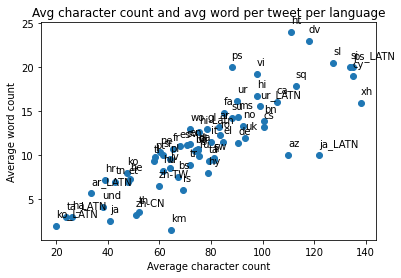

In [14]:
import matplotlib.pyplot as plt

plt.scatter(x= df_train_dev_agg['mean_character_count'], y= df_train_dev_agg['mean_word_count'])

for i in range(len(df_train_dev_agg['mean_word_count'])):
    t = (df_train_dev_agg.iloc[i]['mean_character_count'], df_train_dev_agg.iloc[i]['mean_word_count'])
    plt.annotate(df_train_dev_agg.index.values[i], t, (t[0], t[1]+1))

plt.xlabel("Average character count")
plt.ylabel("Average word count")
plt.title("Avg character count and avg word per tweet per language")

**Observation**:

Each point in the plot above represents a language label. <br>
The points are laid out in 2D based on the average number of words and average number of characters per tweet. <br>
It looks like, that one can discriminate between languages based on these metrices. <br>
Otherwise, all points/languages would clump together. <br>
Hence, I will add the average number of character and the average number of words as new features to the data set.

### 2. Data preparation for training

#### There could be unknown labels in the test set!
#### Hence I create a new category "unknown" and add it to the train set & labels.
#### This is how I ensure that the LabelEncoder can be applied to the test set.

In [15]:
# finding languages with too few tweets

dropped_lang = df_train_dev_grouped[df_train_dev_grouped["tweet"] <= 10].index

for i in range(len(df_train_dev)):
    if df_train_dev.iloc[i]["label"] in dropped_lang:
        df_train_dev.iloc[i]["label"] = "und"

X_train = df_train_dev['tweet']
y_train = df_train_dev['label']
X_test = df_test['tweet']
y_test = df_test['label']

In [16]:
# change any y_test labels which are not in x_test to category "<unknown>"
unknown_labels = np.setdiff1d(y_test, y_train)

i = 0
for l in y_test:
    for ul in unknown_labels:
        if l == ul:
            y_test[i] = "und"
    i += 1

In [17]:
len(np.setdiff1d(y_test, y_train))

0

### Vectorizing the data

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#### Bigrams creation

In [19]:
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),
                             token_pattern = r"(?u)\b\w+\b", 
                             analyzer='char')

X_train_counts = bigram_vectorizer.fit_transform(X_train)
X_test_counts = bigram_vectorizer.transform(X_test)

#### Standardize counts, using "with_mean=False" so I can apply to sparse matrix

In [20]:
stdsc = StandardScaler(with_mean=False)
X_train_std = stdsc.fit_transform(X_train_counts)
X_test_std = stdsc.transform(X_test_counts)

"""compute TfDif for training and test set
tfidf_tranformer = TfidfTransformer(smooth_idf=True).fit(X_train_counts)
X_train_tfidf = tfidf_tranformer.transform(X_train_counts)
X_test_tfidf = tfidf_tranformer.transform(X_train_counts)"""

#### Encode labels

In [21]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

#### Train model
Training SGDClassifier and Multinomial Naïve Bayes


In [22]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier()

sgd_classifier.fit(X_train_std, y_train_enc)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [23]:
from sklearn.metrics import accuracy_score

predictions_sgd = sgd_classifier.predict(X_test_std)

accuracy_score(y_test_enc, predictions_sgd)

0.8401988101513668

In [24]:
from sklearn.naive_bayes import MultinomialNB

mnb_classifier = MultinomialNB()

mnb_classifier.fit(X_train_std, y_train_enc)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [25]:
predictions_mnb = mnb_classifier.predict(X_test_std)

accuracy_score(y_test_enc, predictions_mnb)

0.7973491979817757

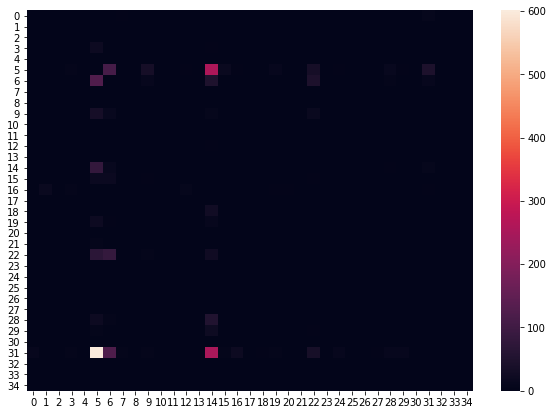

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

conf_m = confusion_matrix(y_test_enc, predictions_mnb)

np.fill_diagonal(conf_m, 0)

plt.figure(figsize = (10,7))
sn.heatmap(conf_m, annot=False)

In [27]:
ind = np.unravel_index(np.argmax(conf_m, axis=None), conf_m.shape)  # returns a tuple
np.unravel_index(np.argmax(conf_m, axis=None), conf_m.shape)  # returns a tuple

(31, 5)

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
pipe_sgd = Pipeline([("vect", CountVectorizer(#ngram_range=(1, 2),
                                                token_pattern = r"(?u)\b\w+\b",
                                                analyzer='char')),
                     ('scl', StandardScaler(with_mean=False)),
                     ('clf', SGDClassifier())], verbose=True)


ngram_range = [(1,1), (1,2), (1,3), (1,4)]

param_grid = [{"vect__ngram_range": ngram_range},
              {"clf__loss": ["hinge", "log", "squared_hinge", "perceptron"]},
              {"clf__penalty": ["l2", "l1", "elasticnet"]},
              {"clf__learning_rate": ["optimal"]}]


gs = GridSearchCV(estimator=pipe_sgd, 
                  param_grid=param_grid, 
                  scoring='accuracy',
                  cv=10,
                  n_jobs=1,
                 verbose=10)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)

print(gs.best_params_) 

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] vect__ngram_range=(1, 1) ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.6s
[CV] ............ vect__ngram_range=(1, 1), score=0.787, total=   8.7s
[CV] vect__ngram_range=(1, 1) ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s


[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.5s
[CV] ............ vect__ngram_range=(1, 1), score=0.810, total=   8.7s
[CV] vect__ngram_range=(1, 1) ........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.4s remaining:    0.0s


[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   8.4s
[CV] ............ vect__ngram_range=(1, 1), score=0.823, total=   9.6s
[CV] vect__ngram_range=(1, 1) ........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.0s remaining:    0.0s


[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.0s
[CV] ............ vect__ngram_range=(1, 1), score=0.819, total=   8.1s
[CV] vect__ngram_range=(1, 1) ........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   35.2s remaining:    0.0s


[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   8.5s
[CV] ............ vect__ngram_range=(1, 1), score=0.814, total=   9.7s
[CV] vect__ngram_range=(1, 1) ........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   44.8s remaining:    0.0s


[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.8s
[CV] ............ vect__ngram_range=(1, 1), score=0.818, total=   9.0s
[CV] vect__ngram_range=(1, 1) ........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   53.8s remaining:    0.0s


[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.1s
[CV] ............ vect__ngram_range=(1, 1), score=0.803, total=   8.2s
[CV] vect__ngram_range=(1, 1) ........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.0min remaining:    0.0s


[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.5s
[CV] ............ vect__ngram_range=(1, 1), score=0.804, total=   8.6s
[CV] vect__ngram_range=(1, 1) ........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.2min remaining:    0.0s


[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.6s
[CV] ............ vect__ngram_range=(1, 1), score=0.817, total=   8.8s
[CV] vect__ngram_range=(1, 1) ........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.3min remaining:    0.0s


[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.9s
[CV] ............ vect__ngram_range=(1, 1), score=0.797, total=   9.0s
[CV] vect__ngram_range=(1, 2) ........................................
[Pipeline] .............. (step 1 of 3) Processing vect, total=   2.8s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.2s
[Pipeline] ............... (step 3 of 3) Processing clf, total=  16.7s
[CV] ............ vect__ngram_range=(1, 2), score=0.828, total=  20.1s
[CV] vect__ngram_range=(1, 2) ........................................
[Pipeline] .............. (step 1 of 3) Processing vect, total=   2.8s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.2s
[Pipeline] ............... (step 3 of 3) Processing clf, total=  17.5s
[CV] ............ vect__ngram_range=(1, 2), score=0.845, total=  21.0s
[CV] v

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 3 of 3) Processing clf, total= 1.4min
[CV] ..................... clf__penalty=l1, score=0.800, total= 1.4min
[CV] clf__penalty=l1 .................................................
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 3 of 3) Processing clf, total= 1.9min
[CV] ..................... clf__penalty=l1, score=0.809, total= 1.9min
[CV] clf__penalty=l1 .................................................
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 3 of 3) Processing clf, total= 1.8min
[CV] ..................... clf__penalty=l1, score=0.818, total= 1.8min
[CV] clf__penalty=l1 .................................................
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 3 of 3) Processing clf, total= 1.7min
[CV] ..................... clf__penalty=l1, score=0.818, total= 1.8min
[CV] clf__penalty=l1 .................................................
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total= 1.7min
[CV] ..................... clf__penalty=l1, score=0.812, total= 1.8min
[CV] clf__penalty=l1 .................................................
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 3 of 3) Processing clf, total= 1.8min
[CV] ..................... clf__penalty=l1, score=0.813, total= 1.8min
[CV] clf__penalty=l1 .................................................
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 3 of 3) Processing clf, total= 1.6min
[CV] ..................... clf__penalty=l1, score=0.807, total= 1.6min
[CV] clf__penalty=l1 .................................................
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 3 of 3) Processing clf, total= 2.0min
[CV] ..................... clf__penalty=l1, score=0.803, total= 2.0min
[CV] clf__penalty=l1 .................................................
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 3 of 3) Processing clf, total= 1.8min
[CV] ..................... clf__penalty=l1, score=0.815, total= 1.8min
[CV] clf__penalty=l1 .................................................
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 3 of 3) Processing clf, total= 1.6min
[CV] ..................... clf__penalty=l1, score=0.799, total= 1.7min
[CV] clf__penalty=elasticnet .........................................
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=  13.1s
[CV] ............. clf__penalty=elasticnet, score=0.786, total=  14.3s
[CV] clf__penalty=elasticnet .........................................
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=  13.2s
[CV] ............. clf__penalty=elasticnet, score=0.814, total=  14.4s
[CV] clf__penalty=elasticnet .........................................
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipel

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 44.2min finished


[Pipeline] .............. (step 1 of 3) Processing vect, total=   3.2s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing clf, total=  19.8s
0.8417846272524777
{'vect__ngram_range': (1, 2)}


In [31]:
## Multinomial Naive Bayes Pipeline
pipe_mnb = Pipeline([("vect", CountVectorizer(#ngram_range=(1, 2),
                                                token_pattern = r"(?u)\b\w+\b",
                                                analyzer='char')),
                     ('scl', StandardScaler(with_mean=False)),
                     ('clf', MultinomialNB())], verbose=True)


ngram_range = [(1,1), (1,2), (1,3), (1,4)]

param_grid = [{"vect__ngram_range": ngram_range},
              #{"clf__loss": ["hinge", "log", "squared_hinge", "perceptron"]},
              #{"clf__penalty": ["l2", "l1", "elasticnet"]},
              #{"clf__learning_rate": ["optimal"]}
              ]


gs_2 = GridSearchCV(estimator=pipe_mnb, 
                  param_grid=param_grid, 
                  scoring='accuracy',
                  cv=10,
                  n_jobs=1,
                 verbose=10)

gs_2 = gs_2.fit(X_train, y_train)
print(gs_2.best_score_)

print(gs_2.best_params_)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] vect__ngram_range=(1, 1) ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.2s
[CV] ............ vect__ngram_range=(1, 1), score=0.704, total=   1.4s
[CV] vect__ngram_range=(1, 1) ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.2s
[CV] ............ vect__ngram_range=(1, 1), score=0.687, total=   1.4s
[CV] vect__ngram_range=(1, 1) ........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s


[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.2s
[CV] ............ vect__ngram_range=(1, 1), score=0.708, total=   1.4s
[CV] vect__ngram_range=(1, 1) ........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.1s remaining:    0.0s


[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.2s
[CV] ............ vect__ngram_range=(1, 1), score=0.702, total=   1.4s
[CV] vect__ngram_range=(1, 1) ........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.5s remaining:    0.0s


[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.2s
[CV] ............ vect__ngram_range=(1, 1), score=0.697, total=   1.4s
[CV] vect__ngram_range=(1, 1) ........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.9s remaining:    0.0s


[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.2s
[CV] ............ vect__ngram_range=(1, 1), score=0.699, total=   1.4s
[CV] vect__ngram_range=(1, 1) ........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    8.3s remaining:    0.0s


[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.2s
[CV] ............ vect__ngram_range=(1, 1), score=0.695, total=   1.4s
[CV] vect__ngram_range=(1, 1) ........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    9.7s remaining:    0.0s


[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.2s
[CV] ............ vect__ngram_range=(1, 1), score=0.696, total=   1.4s
[CV] vect__ngram_range=(1, 1) ........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   11.0s remaining:    0.0s


[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.2s
[CV] ............ vect__ngram_range=(1, 1), score=0.704, total=   1.4s
[CV] vect__ngram_range=(1, 1) ........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   12.4s remaining:    0.0s


[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.2s
[CV] ............ vect__ngram_range=(1, 1), score=0.695, total=   1.4s
[CV] vect__ngram_range=(1, 2) ........................................
[Pipeline] .............. (step 1 of 3) Processing vect, total=   2.7s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.2s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[CV] ............ vect__ngram_range=(1, 2), score=0.801, total=   3.8s
[CV] vect__ngram_range=(1, 2) ........................................
[Pipeline] .............. (step 1 of 3) Processing vect, total=   2.7s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.2s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[CV] ............ vect__ngram_range=(1, 2), score=0.799, total=   3.7s
[CV] v

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  4.7min finished


[Pipeline] .............. (step 1 of 3) Processing vect, total=  12.8s
[Pipeline] ............... (step 2 of 3) Processing scl, total=   0.9s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.0s
0.8282486698529359
{'vect__ngram_range': (1, 4)}


In [33]:
gs_2.__dict__

{'best_estimator_': Pipeline(memory=None,
          steps=[('vect',
                  CountVectorizer(analyzer='char', binary=False,
                                  decode_error='strict',
                                  dtype=<class 'numpy.int64'>, encoding='utf-8',
                                  input='content', lowercase=True, max_df=1.0,
                                  max_features=None, min_df=1,
                                  ngram_range=(1, 4), preprocessor=None,
                                  stop_words=None, strip_accents=None,
                                  token_pattern='(?u)\\b\\w+\\b', tokenizer=None,
                                  vocabulary=None)),
                 ('scl',
                  StandardScaler(copy=True, with_mean=False, with_std=True)),
                 ('clf',
                  MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
          verbose=True),
 'best_index_': 3,
 'best_params_': {'vect__ngram_range': (1, 4)},
 'best_s